In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [2]:
raw_data = pd.read_csv("IPL_Ball_by_Ball_2008_2022.csv")
# raw_data = raw_data.sample(frac=0.05, random_state=42)
raw_data

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225949,335982,2,14,5,P Kumar,I Sharma,SB Joshi,legbyes,0,1,1,0,0,NaN,NaN,NaN,Royal Challengers Bangalore
225950,335982,2,14,6,SB Joshi,I Sharma,P Kumar,NaN,1,0,1,0,0,NaN,NaN,NaN,Royal Challengers Bangalore
225951,335982,2,14,7,P Kumar,I Sharma,SB Joshi,NaN,0,0,0,0,0,NaN,NaN,NaN,Royal Challengers Bangalore
225952,335982,2,15,1,SB Joshi,LR Shukla,P Kumar,wides,0,1,1,0,0,NaN,NaN,NaN,Royal Challengers Bangalore


In [3]:
def over_data(raw_data):
    
    raw_data=raw_data[raw_data['total_run']<=6] # Outliers
    
    over_info = pd.DataFrame()
    
    over_info['overid'] = raw_data['ID']*40+(raw_data['innings']-1)*20+raw_data['overs'] # Unique ID for over
    over_info['type'] = (raw_data['overs']>6).astype(int) + (raw_data['overs']>15).astype(int) # Powerplay/Middle/Death
    
    # Batter Columns
    distinct_batters = raw_data['batter'].unique()
    batter_names = pd.concat([(raw_data['batter'].fillna('').isin([batter]) | raw_data['non-striker'].fillna('').isin([batter])).astype(int) for batter in distinct_batters], axis=1)
    batter_names.columns = distinct_batters
    over_info = pd.concat([over_info,batter_names],axis=1)

    # Bowler Columns
    distinct_bowlers = raw_data['bowler'].unique()
    bowler_names = pd.concat([raw_data['bowler'].fillna('') == bowler for bowler in distinct_bowlers], axis=1).astype(int)
    bowler_names.columns = distinct_bowlers
    over_info = pd.concat([over_info,bowler_names],axis=1)
    
    over_info['total_run'] = raw_data['total_run'] 
    over_info['total_wickets'] = raw_data['isWicketDelivery']
    
    # Grouping each over's information
    over_info = over_info.groupby(over_info['overid']).sum()
    for batter in distinct_batters :
        over_info[batter] = (over_info[batter]>0).astype(int)
    for bowler in distinct_bowlers :
        over_info[bowler]=(over_info[bowler]>0).astype(int)
    
    return over_info

In [4]:
modified_data = over_data(raw_data)
modified_data

,type,YBK Jaiswal,JC Buttler,SV Samson,D Padikkal,SO Hetmyer,R Ashwin,R Parag,TA Boult,OC McCoy,...,Shoaib Malik,S Vidyut,Mohammad Hafeez,LPC Silva,D Kalyankrishna,SB Joshi,MA Khote,AA Noffke,total_run,total_wickets
overid,,,,,,,,,,,,,,,,,,,,,
13439280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
13439281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,0
13439282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0
13439283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,23,0
13439284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52488034,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0
52488035,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
52488036,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,0


In [5]:
X = modified_data.drop(columns = ["total_run","total_wickets"])
Y = modified_data["total_run"]
pca = PCA(n_components=50) 
X = pca.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1092003)

In [6]:
def Linear_Regression(X_train,Y_train):
    regressor = LinearRegression()
    regressor.fit(X_train, Y_train)
    return regressor

In [7]:
print("Using Linear Regression :-")
model_linear_regression = Linear_Regression(X_train,Y_train)
Y_train_pred = model_linear_regression.predict(X_train)
Y_test_pred = model_linear_regression.predict(X_test)
# print("Accuracy on Trained data - ",accuracy_score(Y_train,Y_train_pred))
# print("Classification report on Trained data - \n",classification_report(Y_train,Y_train_pred))
# print("Confusion matrix on Trained data - \n",confusion_matrix(Y_train,Y_train_pred))
# print("Accuracy on Test data - ",accuracy_score(Y_test,Y_test_pred))
# print("Classification report on Test data - \n",classification_report(Y_test,Y_test_pred))
# print("Confusion matrix on Test data - \n",confusion_matrix(Y_test,Y_test_pred))

Using Linear Regression :-


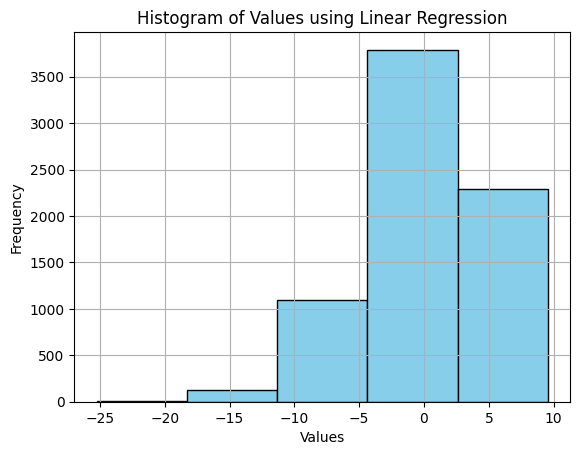

Max error -  9.554427792371527
Average of sum of squared errors : 20.97298616496312


In [10]:
linear_regression_list = []
mx = 0
sse = 0
for _ in range(len(Y_test)):
    linear_regression_list.append(Y_test_pred[_]-Y_test.iloc[_])
    mx = max(mx,Y_test_pred[_]-Y_test.iloc[_])
    sse += (Y_test_pred[_]-Y_test.iloc[_])*(Y_test_pred[_]-Y_test.iloc[_])
sse /= len(Y_test)
# Creating a histogram
plt.hist(linear_regression_list, bins=5, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values using Linear Regression')
plt.grid(True)
plt.show()
print("Max error - ",mx)
print('Average of sum of squared errors :',sse)

In [9]:
avg = np.mean(linear_regression_list)
var = np.var(linear_regression_list)

print("Average:", avg)
print("Variance:", var)

Average: -0.08894155166026313
Variance: 20.965075565351384
